In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-pastel')
pd.set_option('display.max_rows', 200)

### Cleaning

In [4]:
#Import the data
data = pd.read_csv('train.csv')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 78 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         150634 non-null  int64  
 1   Tranc_YearMonth            150634 non-null  object 
 2   town                       150634 non-null  object 
 3   flat_type                  150634 non-null  object 
 4   block                      150634 non-null  object 
 5   street_name                150634 non-null  object 
 6   storey_range               150634 non-null  object 
 7   floor_area_sqm             150634 non-null  float64
 8   flat_model                 150634 non-null  object 
 9   lease_commence_date        150634 non-null  int64  
 10  resale_price               150634 non-null  float64
 11  Tranc_Year                 150634 non-null  int64  
 12  Tranc_Month                150634 non-null  int64  
 13  mid_storey                 15

In [6]:
#standardizing all column names to be in snake case
data.columns = data.columns.str.lower().str.replace(' ','_')

In [7]:
#dropping price_per_sqft since we cannot use this for our prediction
data.drop('price_per_sqft', axis = 1, inplace = True)

In [8]:
data.corr()['resale_price'].sort_values()

3room_sold                  -0.410368
hdb_age                     -0.350337
sec_sch_latitude            -0.216303
latitude                    -0.216153
bus_stop_latitude           -0.215760
mrt_latitude                -0.214939
pri_sch_latitude            -0.214707
2room_sold                  -0.145287
total_dwelling_units        -0.140725
mrt_nearest_distance        -0.128222
mall_nearest_distance       -0.087096
3room_rental                -0.079965
2room_rental                -0.077548
1room_sold                  -0.039434
1room_rental                -0.037993
hawker_food_stalls          -0.033581
tranc_year                  -0.019146
vacancy                     -0.016140
hawker_nearest_distance     -0.014537
pri_sch_nearest_distance    -0.011004
hawker_market_stalls        -0.009378
tranc_month                 -0.006823
affiliation                 -0.000466
bus_interchange              0.002547
other_room_rental            0.013049
pri_sch_affiliation          0.030931
bus_stop_nea

In [9]:
#any columns with only 1 unique value will not be helpful in a prediction model 
for x in data.columns:
    print(x, len(data[x].unique()))

id 150634
tranc_yearmonth 110
town 26
flat_type 7
block 2514
street_name 553
storey_range 25
floor_area_sqm 169
flat_model 20
lease_commence_date 54
resale_price 3295
tranc_year 10
tranc_month 12
mid_storey 22
lower 22
upper 23
mid 22
full_flat_type 43
address 9157
floor_area_sqft 169
hdb_age 54
max_floor_lvl 41
year_completed 59
residential 1
commercial 2
market_hawker 2
multistorey_carpark 2
precinct_pavilion 2
total_dwelling_units 320
1room_sold 2
2room_sold 99
3room_sold 255
4room_sold 200
5room_sold 133
exec_sold 103
multigen_sold 7
studio_apartment_sold 61
1room_rental 11
2room_rental 48
3room_rental 15
other_room_rental 3
postal 17483
latitude 9126
longitude 9098
planning_area 32
mall_nearest_distance 8983
mall_within_500m 7
mall_within_1km 16
mall_within_2km 42
hawker_nearest_distance 9126
hawker_within_500m 6
hawker_within_1km 10
hawker_within_2km 20
hawker_food_stalls 52
hawker_market_stalls 70
mrt_nearest_distance 9126
mrt_name 94
bus_interchange 2
mrt_interchange 2
mrt_lati

In [10]:
#Dropping residential column due to only 1 unique value and id value as it is only use for identification
data.drop(['residential', 'id'], axis = 1, inplace=True)

In [11]:
data.columns

Index(['tranc_yearmonth', 'town', 'flat_type', 'block', 'street_name',
       'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'resale_price', 'tranc_year', 'tranc_month', 'mid_storey', 'lower',
       'upper', 'mid', 'full_flat_type', 'address', 'floor_area_sqft',
       'hdb_age', 'max_floor_lvl', 'year_completed', 'commercial',
       'market_hawker', 'multistorey_carpark', 'precinct_pavilion',
       'total_dwelling_units', '1room_sold', '2room_sold', '3room_sold',
       '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold',
       'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental',
       'other_room_rental', 'postal', 'latitude', 'longitude', 'planning_area',
       'mall_nearest_distance', 'mall_within_500m', 'mall_within_1km',
       'mall_within_2km', 'hawker_nearest_distance', 'hawker_within_500m',
       'hawker_within_1km', 'hawker_within_2km', 'hawker_food_stalls',
       'hawker_market_stalls', 'mrt_nearest_distance', 

In [12]:
data.isnull().sum().sort_values().tail(8)

max_floor_lvl                0
mall_nearest_distance      829
mall_within_2km           1940
mall_within_1km          25426
hawker_within_2km        29202
hawker_within_1km        60868
mall_within_500m         92789
hawker_within_500m       97390
dtype: int64

In [13]:
#Exploring Null Rows - looks like null value are 0 (i.e. no malls within stated distance)
data[data['mall_nearest_distance'].isnull()][['mall_nearest_distance', 'mall_within_500m', 'mall_within_1km', 'mall_within_2km']]

,mall_nearest_distance,mall_within_500m,mall_within_1km,mall_within_2km
75,NaN,NaN,NaN,NaN
321,NaN,NaN,NaN,NaN
478,NaN,NaN,NaN,NaN
643,NaN,NaN,NaN,NaN
691,NaN,NaN,NaN,NaN
...,...,...,...,...
150296,NaN,NaN,NaN,NaN
150388,NaN,NaN,NaN,NaN
150394,NaN,NaN,NaN,NaN
150479,NaN,NaN,NaN,NaN


In [14]:
#filling null values with 0
col_with_null = data.columns[data.isnull().sum() != 0].to_list()
imputer=SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value=0)
for x in col_with_null:
    data[x]=imputer.fit_transform(data[x].values.reshape(-1,1))

In [15]:
#Since machine learning can only take numeric inputs, we will have to convert useful categorical columns to numeric form 
data.select_dtypes(include='object').columns

Index(['tranc_yearmonth', 'town', 'flat_type', 'block', 'street_name',
       'storey_range', 'flat_model', 'full_flat_type', 'address', 'commercial',
       'market_hawker', 'multistorey_carpark', 'precinct_pavilion', 'postal',
       'planning_area', 'mrt_name', 'bus_stop_name', 'pri_sch_name',
       'sec_sch_name'],
      dtype='object')

In [16]:
#Checking if tranc_yearmonth is consistent with 'tranc_year', 'tranc_month'
data[['tranc_yearmonth','tranc_year', 'tranc_month']]

,tranc_yearmonth,tranc_year,tranc_month
0,2016-05,2016,5
1,2012-07,2012,7
2,2013-07,2013,7
3,2012-04,2012,4
4,2017-12,2017,12
...,...,...,...
150629,2020-09,2020,9
150630,2017-06,2017,6
150631,2020-12,2020,12
150632,2016-05,2016,5


In [17]:
#drop trancyear
data.drop('tranc_yearmonth', axis = 1, inplace=True)

In [18]:
#checking if storey_range column is consistent with 'mid_storey', 'lower', 'upper', 'mid'
data[['storey_range','mid_storey', 'lower', 'upper', 'mid']]

,storey_range,mid_storey,lower,upper,mid
0,10 TO 12,11,10,12,11
1,07 TO 09,8,7,9,8
2,13 TO 15,14,13,15,14
3,01 TO 05,3,1,5,3
4,01 TO 03,2,1,3,2
...,...,...,...,...,...
150629,04 TO 06,5,4,6,5
150630,04 TO 06,5,4,6,5
150631,10 TO 12,11,10,12,11
150632,07 TO 09,8,7,9,8


In [19]:
#Checking if mid_storey == mid columns
(data['mid_storey'] == data['mid']).value_counts()

True    150634
dtype: int64

In [20]:
#drop mid_storey
data.drop('mid_storey', axis = 1, inplace=True)

In [21]:
#checking if town == planning_area 
data[['town', 'planning_area']]

,town,planning_area
0,KALLANG/WHAMPOA,Kallang
1,BISHAN,Bishan
2,BUKIT BATOK,Bukit Batok
3,BISHAN,Bishan
4,YISHUN,Yishun
...,...,...
150629,WOODLANDS,Woodlands
150630,JURONG WEST,Jurong West
150631,BEDOK,Bedok
150632,QUEENSTOWN,Queenstown


In [22]:
data['town'] = data['town'].str.lower()
data['planning_area'] = data['planning_area'].str.lower()

In [23]:
data[['town', 'planning_area']]

,town,planning_area
0,kallang/whampoa,kallang
1,bishan,bishan
2,bukit batok,bukit batok
3,bishan,bishan
4,yishun,yishun
...,...,...
150629,woodlands,woodlands
150630,jurong west,jurong west
150631,bedok,bedok
150632,queenstown,queenstown


In [24]:
(data['town'] == data['planning_area']).value_counts()

True     144931
False      5703
dtype: int64

In [25]:
data[(data['town'] == data['planning_area']) == False][['town', 'planning_area']]

,town,planning_area
0,kallang/whampoa,kallang
32,kallang/whampoa,novena
35,kallang/whampoa,kallang
55,kallang/whampoa,kallang
88,central area,rochor
...,...,...
150507,kallang/whampoa,kallang
150510,kallang/whampoa,kallang
150511,kallang/whampoa,kallang
150524,central area,outram


In [26]:
#Planning area is more precise than town so we will drop town since most values are repeated
data.drop('town', axis = 1, inplace=True)

In [27]:
#checking if flat_type and full_flat_type is consistent
(data['flat_type'] == data['full_flat_type']).value_counts()

False    150634
dtype: int64

In [28]:
data[['flat_type', 'full_flat_type', 'flat_model']]

,flat_type,full_flat_type,flat_model
0,4 ROOM,4 ROOM Model A,Model A
1,5 ROOM,5 ROOM Improved,Improved
2,EXECUTIVE,EXECUTIVE Apartment,Apartment
3,4 ROOM,4 ROOM Model A,Model A
4,4 ROOM,4 ROOM Simplified,Simplified
...,...,...,...
150629,EXECUTIVE,EXECUTIVE Apartment,Apartment
150630,5 ROOM,5 ROOM Improved,Improved
150631,EXECUTIVE,EXECUTIVE Apartment,Apartment
150632,3 ROOM,3 ROOM Improved,Improved


In [29]:
#drop full_flat_type 
data.drop('full_flat_type', axis = 1, inplace = True)

In [30]:
#checking remaining object dtype columns and the number of values
for x in data.select_dtypes(include='object').columns:
    print(x, len(data[x].unique()))

flat_type 7
block 2514
street_name 553
storey_range 25
flat_model 20
address 9157
commercial 2
market_hawker 2
multistorey_carpark 2
precinct_pavilion 2
postal 17483
planning_area 32
mrt_name 94
bus_stop_name 1657
pri_sch_name 177
sec_sch_name 134


In [31]:
#dropping block, street_name, address, postal and bus_stop_name as there are too many unique values 
data.drop(['block', 'street_name', 'address', 'postal', 'bus_stop_name'], axis = 1, inplace = True)

In [32]:
#Checking remaining columns
data.columns

Index(['flat_type', 'storey_range', 'floor_area_sqm', 'flat_model',
       'lease_commence_date', 'resale_price', 'tranc_year', 'tranc_month',
       'lower', 'upper', 'mid', 'floor_area_sqft', 'hdb_age', 'max_floor_lvl',
       'year_completed', 'commercial', 'market_hawker', 'multistorey_carpark',
       'precinct_pavilion', 'total_dwelling_units', '1room_sold', '2room_sold',
       '3room_sold', '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold',
       'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental',
       'other_room_rental', 'latitude', 'longitude', 'planning_area',
       'mall_nearest_distance', 'mall_within_500m', 'mall_within_1km',
       'mall_within_2km', 'hawker_nearest_distance', 'hawker_within_500m',
       'hawker_within_1km', 'hawker_within_2km', 'hawker_food_stalls',
       'hawker_market_stalls', 'mrt_nearest_distance', 'mrt_name',
       'bus_interchange', 'mrt_interchange', 'mrt_latitude', 'mrt_longitude',
       'bus_stop_nearest_dis

In [33]:
#dropping longitude and latitude columns
data.drop(['latitude', 'longitude', 'mrt_latitude', 'mrt_longitude', 'bus_stop_latitude', 'bus_stop_longitude', 'pri_sch_latitude', 'pri_sch_longitude', 'sec_sch_latitude', 'sec_sch_longitude'], axis = 1, inplace = True)

In [34]:
#droppping floor_area_sqft becauses we have floor_area_sqm
data.drop('floor_area_sqft', axis = 1, inplace = True)

In [35]:
#dropping lease_commence_date and year_completed because we have hdb_age
data.drop(['lease_commence_date','year_completed'], axis = 1, inplace = True)

In [36]:
data.columns

Index(['flat_type', 'storey_range', 'floor_area_sqm', 'flat_model',
       'resale_price', 'tranc_year', 'tranc_month', 'lower', 'upper', 'mid',
       'hdb_age', 'max_floor_lvl', 'commercial', 'market_hawker',
       'multistorey_carpark', 'precinct_pavilion', 'total_dwelling_units',
       '1room_sold', '2room_sold', '3room_sold', '4room_sold', '5room_sold',
       'exec_sold', 'multigen_sold', 'studio_apartment_sold', '1room_rental',
       '2room_rental', '3room_rental', 'other_room_rental', 'planning_area',
       'mall_nearest_distance', 'mall_within_500m', 'mall_within_1km',
       'mall_within_2km', 'hawker_nearest_distance', 'hawker_within_500m',
       'hawker_within_1km', 'hawker_within_2km', 'hawker_food_stalls',
       'hawker_market_stalls', 'mrt_nearest_distance', 'mrt_name',
       'bus_interchange', 'mrt_interchange', 'bus_stop_nearest_distance',
       'pri_sch_nearest_distance', 'pri_sch_name', 'vacancy',
       'pri_sch_affiliation', 'sec_sch_nearest_dist', 'sec_sch

In [37]:
data.select_dtypes(include='object').columns

Index(['flat_type', 'storey_range', 'flat_model', 'commercial',
       'market_hawker', 'multistorey_carpark', 'precinct_pavilion',
       'planning_area', 'mrt_name', 'pri_sch_name', 'sec_sch_name'],
      dtype='object')

In [38]:
data.select_dtypes(include=('int64', 'float64')).columns

Index(['floor_area_sqm', 'resale_price', 'tranc_year', 'tranc_month', 'lower',
       'upper', 'mid', 'hdb_age', 'max_floor_lvl', 'total_dwelling_units',
       '1room_sold', '2room_sold', '3room_sold', '4room_sold', '5room_sold',
       'exec_sold', 'multigen_sold', 'studio_apartment_sold', '1room_rental',
       '2room_rental', '3room_rental', 'other_room_rental',
       'mall_nearest_distance', 'mall_within_500m', 'mall_within_1km',
       'mall_within_2km', 'hawker_nearest_distance', 'hawker_within_500m',
       'hawker_within_1km', 'hawker_within_2km', 'hawker_food_stalls',
       'hawker_market_stalls', 'mrt_nearest_distance', 'bus_interchange',
       'mrt_interchange', 'bus_stop_nearest_distance',
       'pri_sch_nearest_distance', 'vacancy', 'pri_sch_affiliation',
       'sec_sch_nearest_dist', 'cutoff_point', 'affiliation'],
      dtype='object')

## cleaning stops here

-------------------

# EDA and Features Selection


In [39]:
#checking for number of unique values in each quantitative column
for x in data.select_dtypes(include=('int64', 'float64')).columns:
    print(x, len(data[x].unique()))

floor_area_sqm 169
resale_price 3295
tranc_year 10
tranc_month 12
lower 22
upper 23
mid 22
hdb_age 54
max_floor_lvl 41
total_dwelling_units 320
1room_sold 2
2room_sold 99
3room_sold 255
4room_sold 200
5room_sold 133
exec_sold 103
multigen_sold 7
studio_apartment_sold 61
1room_rental 11
2room_rental 48
3room_rental 15
other_room_rental 3
mall_nearest_distance 8982
mall_within_500m 7
mall_within_1km 16
mall_within_2km 42
hawker_nearest_distance 9126
hawker_within_500m 6
hawker_within_1km 10
hawker_within_2km 20
hawker_food_stalls 52
hawker_market_stalls 70
mrt_nearest_distance 9126
bus_interchange 2
mrt_interchange 2
bus_stop_nearest_distance 9126
pri_sch_nearest_distance 9126
vacancy 66
pri_sch_affiliation 2
sec_sch_nearest_dist 9126
cutoff_point 54
affiliation 2


In [40]:
data.corr()['resale_price']

floor_area_sqm               0.654120
resale_price                 1.000000
tranc_year                  -0.019146
tranc_month                 -0.006823
lower                        0.352466
upper                        0.353552
mid                          0.353213
hdb_age                     -0.350337
max_floor_lvl                0.495650
total_dwelling_units        -0.140725
1room_sold                  -0.039434
2room_sold                  -0.145287
3room_sold                  -0.410368
4room_sold                   0.092600
5room_sold                   0.359434
exec_sold                    0.337500
multigen_sold                0.037406
studio_apartment_sold        0.040312
1room_rental                -0.037993
2room_rental                -0.077548
3room_rental                -0.079965
other_room_rental            0.013049
mall_nearest_distance       -0.092239
mall_within_500m             0.085151
mall_within_1km              0.078815
mall_within_2km              0.108648
hawker_neare

### 1room_sold, mrt_interchange, pri_sch_affiliation, affiliation, bus_interchange

In [41]:
data['1room_sold'].unique()

array([  0, 255], dtype=int64)

In [42]:
#Checking for significant diffferences between flats in blocks with sold 1room flats vs those without
t_statistic, p_value = stats.ttest_ind(data[data['1room_sold'] == 255]['resale_price'], data[data['1room_sold'] == 0]['resale_price'])

print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: -15.316865171784787
p-value: 6.468195886612115e-53


In [43]:
data['mrt_interchange'].unique()

array([0, 1], dtype=int64)

In [44]:
#Checking for significant diffferences between flats with or without mrt station
t_statistic, p_value = stats.ttest_ind(data[data['mrt_interchange'] == 0]['resale_price'], data[data['mrt_interchange'] == 1]['resale_price'])

print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: -25.832962030804353
p-value: 7.919041573029868e-147


In [45]:
data['pri_sch_affiliation'].unique()

array([1, 0], dtype=int64)

In [46]:
#Checking for significant diffferences between flats with pri sch affliations vs those without
t_statistic, p_value = stats.ttest_ind(data[data['pri_sch_affiliation'] == 0]['resale_price'], data[data['pri_sch_affiliation'] == 1]['resale_price'])

print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: -12.010394486100676
p-value: 3.245046093756188e-33


In [47]:
#Checking for significant diffferences between flats with pri sch affliations vs those without
t_statistic, p_value = stats.ttest_ind(data[data['affiliation'] == 0]['resale_price'], data[data['affiliation'] == 1]['resale_price'])

print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: 0.18098733357597738
p-value: 0.8563777616694039


In [48]:
data.drop('affiliation', axis = 1, inplace = True)

In [49]:
data['bus_interchange'].unique()

array([0, 1], dtype=int64)

In [50]:
#Checking for significant diffferences between flats with or without bus stops
t_statistic, p_value = stats.ttest_ind(data[data['bus_interchange'] == 0]['resale_price'], data[data['bus_interchange'] == 1]['resale_price'])

print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: -0.988570893024779
p-value: 0.32287472097030323


In [51]:
data.drop('bus_interchange', axis = 1, inplace = True)

### encoding 

In [52]:
for x in data.select_dtypes(include='object').columns:
    print(x, len(data[x].unique()))

flat_type 7
storey_range 25
flat_model 20
commercial 2
market_hawker 2
multistorey_carpark 2
precinct_pavilion 2
planning_area 32
mrt_name 94
pri_sch_name 177
sec_sch_name 134


### commercial, market_hawker, multistorey_carpark, precinct_pavilion

In [53]:
data['commercial'].unique()

array(['N', 'Y'], dtype=object)

In [54]:
#Checking for significant diffferences between flats with or without commercial units
t_statistic, p_value = stats.ttest_ind(data[data['commercial'] == 'N']['resale_price'], data[data['commercial'] == 'Y']['resale_price'])

print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: 54.94959817005768
p-value: 0.0


In [55]:
data['market_hawker'].unique()

array(['N', 'Y'], dtype=object)

In [56]:
#Checking for significant diffferences between flats with or without market_hawker
t_statistic, p_value = stats.ttest_ind(data[data['market_hawker'] == 'N']['resale_price'], data[data['market_hawker'] == 'Y']['resale_price'])

print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: 2.3052979441153596
p-value: 0.02115124474119538


In [57]:
data['multistorey_carpark'].unique()

array(['N', 'Y'], dtype=object)

In [58]:
#Checking for significant diffferences between flats with or without multistorey carpark
t_statistic, p_value = stats.ttest_ind(data[data['multistorey_carpark'] == 'N']['resale_price'], data[data['multistorey_carpark'] == 'Y']['resale_price'])

print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: 3.0269930389667055
p-value: 0.002470413669327056


In [59]:
#Checking for significant diffferences between flats with or without precinct pavilion
t_statistic, p_value = stats.ttest_ind(data[data['precinct_pavilion'] == 'N']['resale_price'], data[data['precinct_pavilion'] == 'Y']['resale_price'])

print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: -0.2774293051005933
p-value: 0.781450862895485


In [60]:
data.drop('precinct_pavilion', axis = 1, inplace = True)

In [61]:
data.columns

Index(['flat_type', 'storey_range', 'floor_area_sqm', 'flat_model',
       'resale_price', 'tranc_year', 'tranc_month', 'lower', 'upper', 'mid',
       'hdb_age', 'max_floor_lvl', 'commercial', 'market_hawker',
       'multistorey_carpark', 'total_dwelling_units', '1room_sold',
       '2room_sold', '3room_sold', '4room_sold', '5room_sold', 'exec_sold',
       'multigen_sold', 'studio_apartment_sold', '1room_rental',
       '2room_rental', '3room_rental', 'other_room_rental', 'planning_area',
       'mall_nearest_distance', 'mall_within_500m', 'mall_within_1km',
       'mall_within_2km', 'hawker_nearest_distance', 'hawker_within_500m',
       'hawker_within_1km', 'hawker_within_2km', 'hawker_food_stalls',
       'hawker_market_stalls', 'mrt_nearest_distance', 'mrt_name',
       'mrt_interchange', 'bus_stop_nearest_distance',
       'pri_sch_nearest_distance', 'pri_sch_name', 'vacancy',
       'pri_sch_affiliation', 'sec_sch_nearest_dist', 'sec_sch_name',
       'cutoff_point'],
      dt

### definition

In [62]:
def calculate_quantiles(x):
    return pd.Series([x.quantile(0.25), x.quantile(0.5), x.quantile(0.75), np.std(x)], index=['Q1', 'Q2', 'Q3', 'Std Dev'])

In [63]:
def replaceterm(data_col, listofvalues, newterm):
    return data[data_col].replace(listofvalues, newterm, inplace = True)

### Storey Range

In [64]:
replaceterm('storey_range', ['01 TO 05', '01 TO 03', '04 TO 06'], 1)
replaceterm('storey_range', ['07 TO 09', '06 TO 10'], 2)
replaceterm('storey_range', ['10 TO 12', '13 TO 15', '11 TO 15'], 3)
replaceterm('storey_range', ['16 TO 18', '16 TO 20', '19 TO 21',], 4)
replaceterm('storey_range', ['21 TO 25', '22 TO 24'], 5)
replaceterm('storey_range', [ '25 TO 27', '26 TO 30', '28 TO 30'], 6)
replaceterm('storey_range', ['31 TO 33', '31 TO 35', '36 TO 40', '34 TO 36', '37 TO 39'], 7)
replaceterm('storey_range', ['43 TO 45', '40 TO 42', '49 TO 51', '46 TO 48'], 8)

### flat_type

In [65]:
data.groupby('flat_type')['resale_price'].apply(calculate_quantiles).unstack()

,Q1,Q2,Q3,Std Dev
flat_type,,,,
1 ROOM,185000.0,209000.0,230000.0,25157.510690
2 ROOM,222000.0,245000.0,265000.0,35645.399904
3 ROOM,284000.0,318000.0,355000.0,68183.242489
4 ROOM,373000.0,420000.0,480000.0,109952.991210
5 ROOM,445000.0,500000.0,590000.0,134931.827799
EXECUTIVE,560000.0,615000.0,690000.0,108538.078981
MULTI-GENERATION,719500.0,765500.0,815750.0,77169.603401


Text(0.5, 1.0, 'Resale Price vs Flat Type')

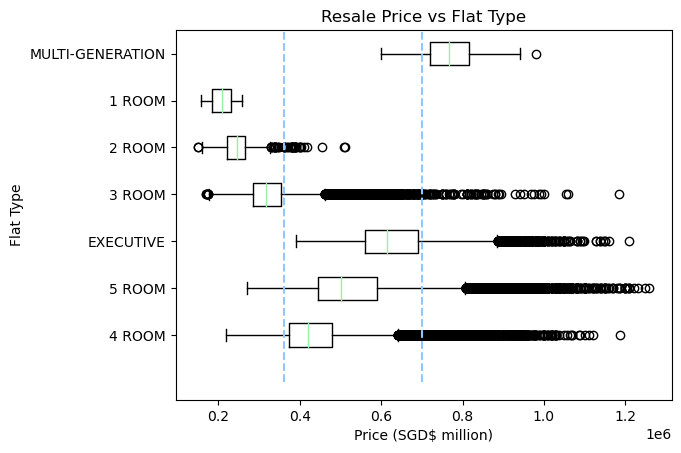

In [66]:
flat_type_list = []
for x in data['flat_type'].unique():
    price = data[data['flat_type'] == x]['resale_price'].to_list()
    flat_type_list.append(price)
plt.boxplot(flat_type_list, vert=False)
locs, labels = plt.yticks()
plt.yticks(locs, data['flat_type'].unique())
plt.xlabel('Price (SGD$ million)')
plt.ylabel('Flat Type')
plt.vlines(360000, ymin = 0, ymax=7.5, linestyles='dashed')
plt.vlines(700000, ymin = 0, ymax=7.5, linestyles='dashed')
plt.title('Resale Price vs Flat Type')

In [67]:
low_flat_type = ['1 ROOM', '2 ROOM', '3 ROOM']
mid_flat_type = ['EXECUTIVE', '5 ROOM', '4 ROOM']
high_flat_type = ['MULTI-GENERATION']

In [68]:
replaceterm('flat_type', low_flat_type, 'low')
replaceterm('flat_type', mid_flat_type, 'mid')
replaceterm('flat_type', high_flat_type, 'high')

### flat_model

Text(0.5, 1.0, 'Resale Price vs Flat Model')

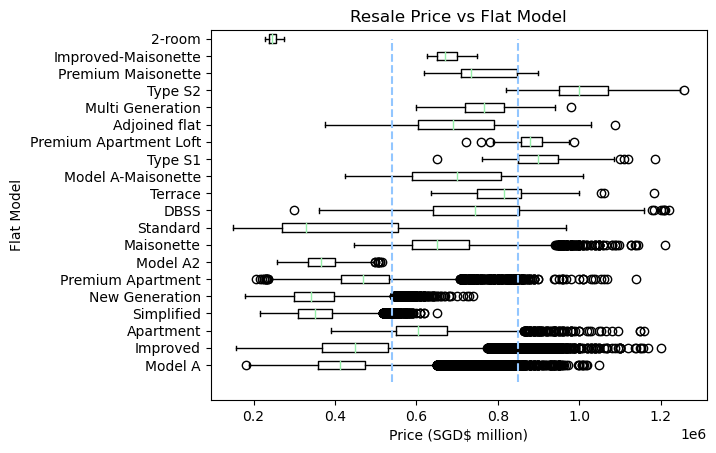

In [69]:
flat_model_list = []
for x in data['flat_model'].unique():
    price = data[data['flat_model'] == x]['resale_price'].to_list()
    flat_model_list.append(price)
plt.boxplot(flat_model_list, vert=False)
locs, labels = plt.yticks()
plt.yticks(locs, data['flat_model'].unique())
plt.xlabel('Price (SGD$ million)')
plt.ylabel('Flat Model')
plt.vlines(540000, ymin = 0, ymax=20, linestyles='dashed')
plt.vlines(850000, ymin = 0, ymax=20, linestyles='dashed')
plt.title('Resale Price vs Flat Model')

In [70]:
#Doing ordinal encoding for flat_model
low_flat_model = ['2-room', 'Standard', 'Model A2', 'Premium Apartment', 'New Generation', 'Simplified', 'Improved', 'Model A']
high_flat_model = ['Type S2', 'Premium Apartment Loft', 'Type S1']
mid_flat_model = [x for x in data['flat_model'].unique().tolist() if x not in (low_flat_model + high_flat_model)]

In [71]:
replaceterm('flat_model', low_flat_model, 'low')
replaceterm('flat_model', mid_flat_model, 'mid')
replaceterm('flat_model', high_flat_model, 'high')

### planning_area

In [72]:
data.groupby('planning_area')['resale_price'].apply(calculate_quantiles).unstack()

,Q1,Q2,Q3,Std Dev
planning_area,,,,
ang mo kio,308000.0,365000.0,473000.0,149769.234387
bedok,310000.0,380000.0,492000.0,138513.224231
bishan,498000.0,595000.0,738000.0,173598.909610
bukit batok,300000.0,368000.0,463000.0,124123.578664
bukit merah,370000.0,568000.0,725000.0,199466.016881
bukit panjang,354000.0,425000.0,498000.0,104823.940018
bukit timah,555350.0,705500.0,873750.0,194277.747497
changi,280000.0,295000.0,305375.0,22291.357654
choa chu kang,350000.0,401000.0,463000.0,84266.344422


Text(0.5, 1.0, 'Resale Price vs Planning Area')

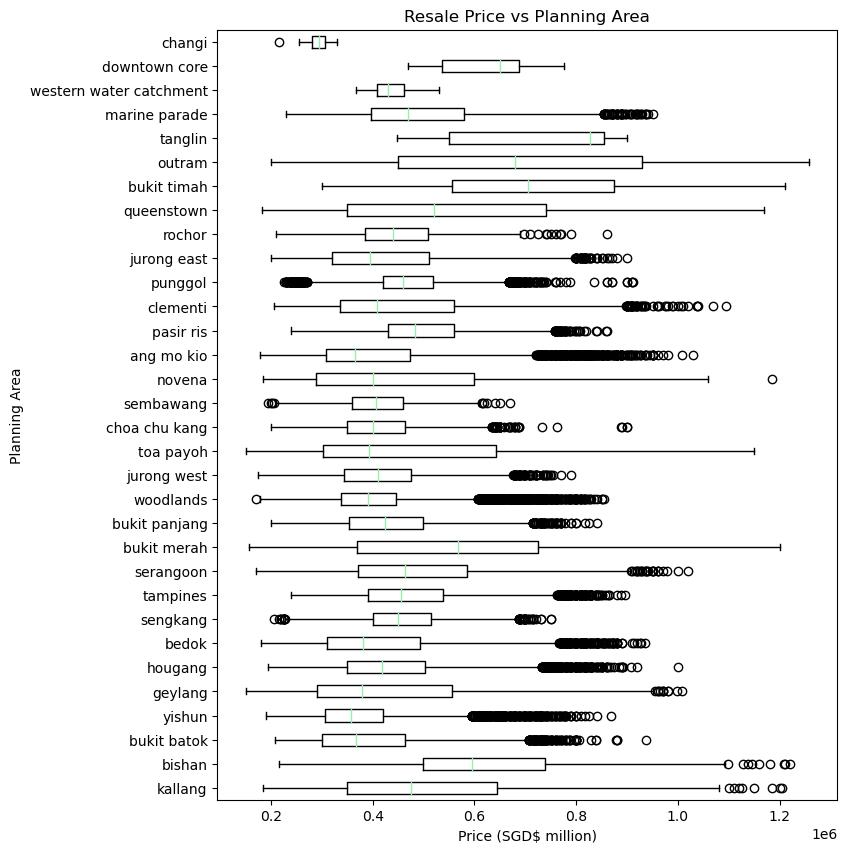

In [73]:
planning_area_list = []
for x in data['planning_area'].unique():
    price = data[data['planning_area'] == x]['resale_price'].to_list()
    planning_area_list.append(price)
plt.figure(figsize=(8,10))
plt.boxplot(planning_area_list, vert=False)
locs, labels = plt.yticks()
plt.yticks(locs, data['planning_area'].unique())
plt.xlabel('Price (SGD$ million)')
plt.ylabel('Planning Area')
plt.title('Resale Price vs Planning Area')

In [74]:
data['planning_area'].unique()

array(['kallang', 'bishan', 'bukit batok', 'yishun', 'geylang', 'hougang',
       'bedok', 'sengkang', 'tampines', 'serangoon', 'bukit merah',
       'bukit panjang', 'woodlands', 'jurong west', 'toa payoh',
       'choa chu kang', 'sembawang', 'novena', 'ang mo kio', 'pasir ris',
       'clementi', 'punggol', 'jurong east', 'rochor', 'queenstown',
       'bukit timah', 'outram', 'tanglin', 'marine parade',
       'western water catchment', 'downtown core', 'changi'], dtype=object)

In [75]:
low_area = ['ang mo kio', 'bedok', 'bukit batok', 'bukit panjang', 'changi', 'choa chu kang', 'jurong west', 'sembawang', 'western water catchment', 'woodlands', 'yishun']
mid1_area = ['bukit merah', 'kallang', 'queenstown']
mid2_area = ['clementi', 'geylang', 'hougang', 'jurong east', 'marine parade', 'novena', 'pasir ris', 'punggol', 'rochor', 'sengkang', 'serangoon', 'tampines', 'toa payoh']
high_area = ['downtown core', 'tanglin', 'outram', 'bukit timah', 'bishan']

In [76]:
replaceterm('planning_area', low_area, 'low')
replaceterm('planning_area', mid1_area, 'mid1')
replaceterm('planning_area', mid2_area, 'mid2')
replaceterm('planning_area', high_area, 'high')

### mrt_name

In [77]:
data.groupby('mrt_name')['resale_price'].apply(calculate_quantiles).unstack()

,Q1,Q2,Q3,Std Dev
mrt_name,,,,
Admiralty,358000.0,400000.0,440000.0,70793.914395
Aljunied,320000.0,376000.0,523500.0,151976.186933
Ang Mo Kio,315000.0,378000.0,515000.0,158096.074579
Bartley,411750.0,485000.0,585750.0,111296.162942
Beauty World,675000.0,777500.0,915000.0,144623.957462
Bedok,315000.0,370500.0,488000.0,145580.097298
Bedok North,290000.0,330000.0,420200.0,119766.862486
Bedok Reservoir,300000.0,358000.0,505000.0,126420.703676
Bencoolen,440200.0,477500.0,538750.0,86566.514936


In [78]:
low_mrt = ['Admiralty', 'Bedok', 'Bedok North', 'Boon Lay', 'Braddell', 'Bukit Batok', 'Bukit Gombak','Bukit Panjang', 'Canberra', 'Cashew', 'Changi Airport', 'Chinatown', 'Chinese Garden', 'Choa Chu Kang', 'Clarke Quay', 'Hougang', 'Khatib', 'Lakeside', 'MacPherson', 'Marsiling', 'Mattar', 'Nicoll Highway', 'Pioneer', 'Rochor', 'Sembawang', 'Tai Seng', 'Tanah Merah', 'Ubi', 'Woodlands North', 'Woodlands South', 'Yew Tee', 'Yio Chu Kang', 'Yishun']
mid1_mrt = ['Aljunied', 'Ang Mo Kio', 'Bartley', 'Bedok Reservoir', 'Bencoolen', 'Botanic Gardens', 'Buangkok', 'Bugis', 'Clementi', 'Dakota', 'Geylang Bahru', 'HarbourFront', 'Jalan Besar', 'Jurong East', 'Kaki Bukit', 'Kovan', 'Little India', 'Pasir Ris', 'Paya Lebar', 'Potong Pasir', 'Punggol', 'Sengkang', 'Simei', 'Tampines', 'Tampines East', 'Tampines West', 'Woodlands', 'Woodleigh']
mid2_mrt = ['Boon Keng', 'Buona Vista', 'Commonwealth', 'Dover', 'Eunos', 'Farrer Park', 'Hillview', 'Holland Village', 'Kallang', 'Kembangan', 'Lavender', 'Lorong Chuan', 'Marymount', 'Mountbatten', 'Queenstown', 'Serangoon', 'Telok Blangah', 'Tiong Bahru', 'Toa Payoh', 'Upper Changi', 'one-north']
high_mrt = ['Beauty World', 'Bendemeer', 'Bishan', 'Bras Basah', 'Caldecott', 'Farrer Road', 'Labrador Park', 'Novena', 'Outram Park', 'Redhill', 'Tan Kah Kee', 'Tanjong Pagar']

In [79]:
replaceterm('mrt_name', low_mrt, 1)
replaceterm('mrt_name', mid1_mrt, 2)
replaceterm('mrt_name', mid2_mrt, 3)
replaceterm('mrt_name', high_mrt, 4)

In [80]:
data['mrt_name'].value_counts()

1    68882
2    58745
3    18722
4     4285
Name: mrt_name, dtype: int64

### pri_sch_name

In [81]:
data.groupby('pri_sch_name')['resale_price'].apply(calculate_quantiles).unstack()

,Q1,Q2,Q3,Std Dev
pri_sch_name,,,,
Admiralty Primary School,374000.00,418000.0,470000.0,76159.834784
Ahmad Ibrahim Primary School,280000.00,313500.0,360000.0,62692.207293
Ai Tong School,373500.00,531888.0,668444.0,175155.346419
Alexandra Primary School,389250.00,527500.0,737722.0,199265.523261
Anchor Green Primary School,400000.00,443500.0,520000.0,79456.011223
Anderson Primary School,305000.00,355000.0,467375.0,112441.544495
Ang Mo Kio Primary School,305000.00,355000.0,428000.0,119102.891660
Angsana Primary School,375000.00,438000.0,510000.0,92494.314361
Beacon Primary School,345000.00,396000.0,450000.0,71691.796823


In [82]:
low_pri = data.groupby('pri_sch_name')['resale_price'].apply(calculate_quantiles).unstack()[data.groupby('pri_sch_name')['resale_price'].apply(calculate_quantiles).unstack()['Q3']<550000].index.tolist()
mid1_pri = ['Anchor Green Primary School', 'Montfort Junior School', 'North Vista Primary School', 'Yuhua Primary School', 'Springdale Primary School', 'Pei Chun Public School', 'Casuarina Primary School', 'Pasir Ris Primary School', 'Palm View Primary School', 'Jing Shan Primary School', 'Cedar Primary School', 'Tao Nan School', 'CHIJ Our Lady of The Nativity', 'Bendemeer Primary School', 'Park View Primary School', 'Nanyang Primary School', 'Farrer Park Primary School', 'Poi Ching School', 'Radin Mas Primary School']
mid2_pri = ['New Town Primary School', 'Temasek Primary School', 'Eunos Primary School','Geylang Methodist School', 'Yangzheng Primary School', 'Guangyang Primary School', 'Pei Tong Primary School', 'Blangah Rise Primary School', 'Haig Girls\' School', 'Maris Stella High School', 'Ai Tong School', 'CHIJ Our Lady Queen of Peace', 'Hong Wen School', 'Qihua Primary School', 'Tampines Primary School', 'CHIJ Primary', 'River Valley Primary School', 'Fairfield Methodist School', 'Nan Hua Primary School', 'Alexandra Primary School', 'Ngee Ann Primary School', 'Kong Hwa School', 'Zhangde Primary School', 'Kheng Cheng School', 'Henry Park Primary School', 'Queenstown Primary School']
high_pri = data.groupby('pri_sch_name')['resale_price'].apply(calculate_quantiles).unstack()[data.groupby('pri_sch_name')['resale_price'].apply(calculate_quantiles).unstack()['Q1']>468000].index.tolist()

In [83]:
replaceterm('pri_sch_name', low_pri, 'low')
replaceterm('pri_sch_name', mid1_pri, 'mid1')
replaceterm('pri_sch_name', mid2_pri, 'mid2')
replaceterm('pri_sch_name', high_pri, 'high')

### sec_sch_name

In [84]:
data.groupby('sec_sch_name')['resale_price'].apply(calculate_quantiles).unstack()

,Q1,Q2,Q3,Std Dev
sec_sch_name,,,,
Admiralty Secondary School,360000.0,400000.0,441888.0,69472.705518
Ahmad Ibrahim Secondary School,280000.0,315000.0,365000.0,66017.866440
Anderson Secondary School,311000.0,373000.0,629500.0,191267.230606
Ang Mo Kio Secondary School,335000.0,428400.0,578000.0,162905.574947
Anglican High School,300000.0,345000.0,414500.0,90427.267551
Anglo-Chinese School,590000.0,622500.0,644750.0,42973.567457
Assumption English School,328750.0,369750.0,608750.0,169413.746675
Bartley Secondary School,260000.0,320000.0,538750.0,170247.850513
Beatty Secondary School,280000.0,346000.0,578000.0,187913.145628


In [85]:
low_sec = ['Woodlands Secondary School','Ahmad Ibrahim Secondary School','Dunearn Secondary School','Yishun Secondary School','Tanglin Secondary School','Marsiling Secondary School','CHIJ Saint Nicholas Girls\' School','Hong Kah Secondary School','Juying Secondary School','Anglican High School','Northland Secondary School','Northbrooks Secondary School','Yio Chu Kang Secondary School','Damai Secondary School','Fuhua Secondary School','Kent Ridge Secondary School','Greenridge Secondary School','Evergreen Secondary School','Mayflower Secondary School','River Valley High School','Hua Yi Secondary School','Teck Whye Secondary School','Xinmin Secondary School','Yishun Town Secondary School','Admiralty Secondary School','Hillgrove Secondary School','Canberra Secondary School','Commonwealth Secondary School','Ping Yi Secondary School','Deyi Secondary School','Woodlands Ring Secondary School','Bukit Panjang Government High School','Chua Chu Kang Secondary School','Yuhua Secondary School','Woodgrove Secondary School','Westwood Secondary School','Kranji Secondary School','Orchid Park Secondary School','Christ Church Secondary School','Pei Hwa Secondary School','Naval Base Secondary School','CHIJ Saint Joseph\'s Convent','Yuying Secondary School','Unity Secondary School','Fuchun Secondary School','Sembawang Secondary School','Bukit Batok Secondary School','Yuan Ching Secondary School','Pasir Ris Secondary School','Punggol Secondary School','Hougang Secondary School','Jurong Secondary School','Swiss Cottage Secondary School','West Spring Secondary School','Zhenghua Secondary School','Holy Innocents\' High School','Boon Lay Secondary School','Greendale Secondary School','Presbyterian High School','Dunman Secondary School','Jurong West Secondary School','East Spring Secondary School','Montfort Secondary School','Saint Andrew\'s Secondary School','Saint Hilda\'s Secondary School','Peicai Secondary School','Bedok Green Secondary School','Serangoon Garden Secondary School','Loyang Secondary School','Raffles Institution','Ngee Ann Secondary School','Paya Lebar Methodist Girls\' School','Regent Secondary School','Compassvale Secondary School','Seng Kang Secondary School','Raffles Girls\' School','Bartley Secondary School','Jurongville Secondary School','Edgefield Secondary School','Cedar Girls\' Secondary School','Nan Chiau High School','Geylang Methodist School','Bukit View Secondary School']
mid1_sec = ['Saint Patrick\'s School','Tampines Secondary School','North Vista Secondary School','Bedok View Secondary School','Meridian Secondary School','Riverside Secondary School','Dunman High School','Pasir Ris Crest Secondary School','Manjusri Secondary School','Junyuan Secondary School','Changkat Changi Secondary School','Zhonghua Secondary School','Clementi Town Secondary School','Ang Mo Kio Secondary School','Beatty Secondary School','Saint Anthony\'s Canossian Secondary School','Yusof Ishak Secondary School','Saint Margaret\'s Secondary School','Fajar Secondary School']
mid2_sec = ['CHIJ Saint Theresa\'s Convent','Bowen Secondary School','Assumption English School','Queensway Secondary School','Bendemeer Secondary School','Anderson Secondary School','Temasek Junior College','Tanjong Katong Secondary School','Serangoon Secondary School','Guangyang Secondary School','Saint Gabriel\'s Secondary School','New Town Secondary School','Hai Sing Catholic School','Chung Cheng High School','Springfield Secondary School','Temasek Secondary School','Peirce Secondary School','Nan Hua High School','Bukit Merah Secondary School','Fairfield Methodist School','Gan Eng Seng School','CHIJ Secondary','CHIJ Katong Convent','Broadrick Secondary School','Outram Secondary School']
high_sec = ['Crescent Girls\' School','Queenstown Secondary School','Methodist Girls\' School','Anglo-Chinese School','Catholic High School','Whitley Secondary School','Kuo Chuan Presbyterian Secondary School']

In [86]:
replaceterm('sec_sch_name', low_sec, 'low')
replaceterm('sec_sch_name', mid1_sec, 'mid1')
replaceterm('sec_sch_name', mid2_sec, 'mid2')
replaceterm('sec_sch_name', high_sec, 'high')

### dummify 

In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150634 entries, 0 to 150633
Data columns (total 50 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   flat_type                  150634 non-null  object 
 1   storey_range               150634 non-null  int64  
 2   floor_area_sqm             150634 non-null  float64
 3   flat_model                 150634 non-null  object 
 4   resale_price               150634 non-null  float64
 5   tranc_year                 150634 non-null  int64  
 6   tranc_month                150634 non-null  int64  
 7   lower                      150634 non-null  int64  
 8   upper                      150634 non-null  int64  
 9   mid                        150634 non-null  int64  
 10  hdb_age                    150634 non-null  int64  
 11  max_floor_lvl              150634 non-null  int64  
 12  commercial                 150634 non-null  object 
 13  market_hawker              15

In [88]:
data['sec_sch_name']

0          low
1         high
2         mid1
3         high
4          low
          ... 
150629     low
150630     low
150631    mid1
150632    mid2
150633     low
Name: sec_sch_name, Length: 150634, dtype: object

In [89]:
encoded_data = pd.get_dummies(data, columns=['1room_sold', 'mrt_interchange', 'pri_sch_affiliation', 'planning_area', 'flat_model', 'flat_type', 'multistorey_carpark', 'commercial', 'market_hawker', 'pri_sch_name', 'sec_sch_name'], drop_first=True)

### Creating interactions terms

In [90]:
encoded_data.shape

(150634, 58)

In [91]:
encoded_data['sqm_year_max_floor'] = encoded_data['floor_area_sqm'] * encoded_data['tranc_year'] * encoded_data['max_floor_lvl']
encoded_data['max_floor_5room'] = encoded_data['max_floor_lvl'] * encoded_data['5room_sold']
encoded_data['age_3room'] = encoded_data['hdb_age'] * encoded_data['3room_sold']
encoded_data['floor_hawker2km'] = encoded_data['mid'] * encoded_data['hawker_within_2km']

In [92]:
encoded_data['age_totalunit'] = encoded_data['hdb_age'] * encoded_data['total_dwelling_units']
encoded_data['year_floor'] = encoded_data['tranc_year'] * encoded_data['mid']
encoded_data['maxfloor_secsch'] = encoded_data['max_floor_lvl'] * encoded_data['sec_sch_nearest_dist']
encoded_data['year_age'] = encoded_data['tranc_year'] * encoded_data['hdb_age']

In [93]:
encoded_data['age_execsold'] = encoded_data['hdb_age'] * encoded_data['exec_sold']
encoded_data['age_pri_sch'] = encoded_data['hdb_age'] * encoded_data['pri_sch_nearest_distance']
encoded_data['floor_hawker'] = encoded_data['mid'] * encoded_data['hawker_market_stalls']
encoded_data['floor_mall1km'] = encoded_data['mid'] * encoded_data['mall_within_1km']

In [94]:
encoded_data['which_floor'] = encoded_data['mid'] * encoded_data['storey_range']
encoded_data['floor_maxfloor'] = encoded_data['max_floor_lvl'] * encoded_data['which_floor']

In [95]:
selected_col = ['floor_area_sqm', 'pri_sch_name_low','max_floor_lvl', 'flat_model_low', 'sec_sch_name_low', 'hdb_age', 'hawker_within_2km',
'mrt_nearest_distance', 'flat_model_mid', 'mrt_name', 'mid', 'planning_area_low', 'sec_sch_nearest_dist',
'mall_within_2km', 'sqm_year_max_floor', 'max_floor_5room', 'age_3room', 'floor_hawker2km', 'age_totalunit', 'year_floor', 'maxfloor_secsch', 'year_age', 'age_execsold', 'age_pri_sch', 'floor_hawker', 'floor_mall1km', 'storey_range', 'which_floor', 'floor_maxfloor']

In [96]:
X = encoded_data[selected_col]
y = data['resale_price']

In [97]:
X.skew().sort_values()

flat_model_low         -2.912722
pri_sch_name_low       -0.967164
sec_sch_name_low       -0.850126
hdb_age                -0.196927
year_age               -0.196583
planning_area_low       0.133869
floor_area_sqm          0.271862
mrt_name                0.879497
hawker_within_2km       1.145569
mrt_nearest_distance    1.146725
storey_range            1.191352
sqm_year_max_floor      1.357442
mid                     1.557997
year_floor              1.559332
sec_sch_nearest_dist    1.812095
max_floor_lvl           2.029228
age_pri_sch             2.254331
age_totalunit           2.421883
age_3room               2.704827
flat_model_mid          2.975420
max_floor_5room         3.026984
maxfloor_secsch         3.088535
floor_hawker            3.159103
floor_mall1km           3.493342
floor_hawker2km         3.732120
age_execsold            3.914698
which_floor             4.115707
mall_within_2km         4.634232
floor_maxfloor          7.407588
dtype: float64

In [98]:
min(encoded_data['max_floor_5room'])

0

In [99]:
skew_list_log = ['floor_maxfloor', 'which_floor', 'maxfloor_secsch']

for x in skew_list_log:
    X[x] = np.log(X[x])

In [100]:
skew_list = ['mall_within_2km', 'age_execsold', 'floor_hawker2km', 'floor_mall1km', 'floor_hawker', 'max_floor_5room']

for x in skew_list:
    X[x] = np.sqrt(X[x])

In [101]:
X.skew()

floor_area_sqm          0.271862
pri_sch_name_low       -0.967164
max_floor_lvl           2.029228
flat_model_low         -2.912722
sec_sch_name_low       -0.850126
hdb_age                -0.196927
hawker_within_2km       1.145569
mrt_nearest_distance    1.146725
flat_model_mid          2.975420
mrt_name                0.879497
mid                     1.557997
planning_area_low       0.133869
sec_sch_nearest_dist    1.812095
mall_within_2km         1.281302
sqm_year_max_floor      1.357442
max_floor_5room         0.880558
age_3room               2.704827
floor_hawker2km         1.275237
age_totalunit           2.421883
year_floor              1.559332
maxfloor_secsch        -0.014426
year_age               -0.196583
age_execsold            2.902259
age_pri_sch             2.254331
floor_hawker            0.554548
floor_mall1km           0.553888
storey_range            1.191352
which_floor             0.013269
floor_maxfloor          0.140323
dtype: float64

In [102]:
scaler = MinMaxScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [103]:
X

,floor_area_sqm,pri_sch_name_low,max_floor_lvl,flat_model_low,sec_sch_name_low,hdb_age,hawker_within_2km,mrt_nearest_distance,flat_model_mid,mrt_name,...,year_floor,maxfloor_secsch,year_age,age_execsold,age_pri_sch,floor_hawker,floor_mall1km,storey_range,which_floor,floor_maxfloor
0,90.0,0,25,1,1,15,13.0,330.083069,0,3,...,22176,10.256460,30240,0.000000,17079.501324,25.690465,0.000000,3,3.496508,6.715383
1,130.0,0,9,1,0,34,7.0,903.659703,0,4,...,16096,8.301782,68408,0.000000,14130.650141,24.819347,2.828427,2,2.772589,4.969813
2,144.0,1,16,0,0,24,1.0,1334.251197,1,1,...,28182,7.965960,48312,37.947332,11972.376930,36.469165,0.000000,3,3.737670,6.510258
3,103.0,0,11,1,0,29,9.0,907.453484,0,4,...,6036,8.362799,58348,0.000000,11295.950305,16.062378,1.732051,1,1.098612,3.496508
4,83.0,1,4,1,1,34,1.0,412.343032,0,1,...,4034,7.129379,68578,0.000000,13640.819864,0.000000,1.414214,1,0.693147,2.079442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150629,161.0,1,12,0,1,26,3.0,713.675852,1,2,...,10100,7.731351,52520,32.249031,10893.583083,0.000000,4.472136,1,1.609438,4.094345
150630,110.0,1,16,1,1,20,1.0,239.773531,0,1,...,10085,9.193265,40340,0.000000,2725.961605,21.679483,2.236068,1,1.609438,4.382027
150631,144.0,1,15,0,0,28,4.0,669.284215,1,2,...,22220,9.030418,56560,39.597980,14353.550790,28.722813,0.000000,3,3.496508,6.204558
150632,59.0,0,10,1,0,47,8.0,502.030710,0,3,...,16128,9.026882,94752,0.000000,37000.794964,22.449944,4.898979,2,2.772589,5.075174


---------------------

### Train-Test Split and checking Model Score

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=5)

In [105]:
#no skew no scale
lr = LinearRegression()
lr.fit(X_train, y_train)
print(lr.intercept_)
print(lr.coef_)
print('Linear Regression score:',lr.score(X_train,y_train))
lrpred=lr.predict(X_test)
print('Mean Squared Error: ',mean_squared_error(y_test,lrpred))
print('Mean Absolute Error: ',mean_absolute_error(y_test,lrpred))
print('Root Mean Squared Error: ',np.sqrt(mean_squared_error(y_test,lrpred)))
print('Test Score: ',lr.score(X_test, y_test))

446550.6097619054
[ 5.91522144e+05 -1.64420646e+04 -9.72603306e+04 -5.18695524e+04
 -1.77024087e+04  2.67948025e+07  7.70155988e+04 -1.43786697e+05
  2.78980933e+04  6.66454501e+04 -2.17006929e+07 -3.32146332e+04
 -3.08548774e+04 -7.31945426e+04  5.17194670e+05 -3.04048455e+04
 -4.45320323e+04  1.38361578e+05 -3.16956743e+03  2.17522237e+07
  3.32929122e+04 -2.69937962e+07 -4.85152756e+04  3.64216088e+04
  8.81232519e+04  5.85049536e+04 -3.38672525e+03  3.83946298e+05
 -5.98067312e+05]
Linear Regression score: 0.8628645748861994
Mean Squared Error:  2774914756.5746236
Mean Absolute Error:  39873.02334651694
Root Mean Squared Error:  52677.45966326227
Test Score:  0.8648744345532383


In [106]:
set(zip(X.columns, lr.coef_))

{('age_3room', -44532.03233368664),
 ('age_execsold', -48515.27555637159),
 ('age_pri_sch', 36421.60877168352),
 ('age_totalunit', -3169.5674340966925),
 ('flat_model_low', -51869.55241269164),
 ('flat_model_mid', 27898.093328605057),
 ('floor_area_sqm', 591522.1437856737),
 ('floor_hawker', 88123.25187700614),
 ('floor_hawker2km', 138361.5776784639),
 ('floor_mall1km', 58504.9536261038),
 ('floor_maxfloor', -598067.312393124),
 ('hawker_within_2km', 77015.5988086328),
 ('hdb_age', 26794802.508557264),
 ('mall_within_2km', -73194.5425978183),
 ('max_floor_5room', -30404.845470481017),
 ('max_floor_lvl', -97260.3305516736),
 ('maxfloor_secsch', 33292.91221356814),
 ('mid', -21700692.928847115),
 ('mrt_name', 66645.45009797753),
 ('mrt_nearest_distance', -143786.6972124726),
 ('planning_area_low', -33214.6332404103),
 ('pri_sch_name_low', -16442.064574958087),
 ('sec_sch_name_low', -17702.40873761863),
 ('sec_sch_nearest_dist', -30854.87742532236),
 ('sqm_year_max_floor', 517194.66996001

In [107]:
print("R2 Score:", r2_score(y_test, lrpred))
print("Train Score:", lr.score(X_train, y_train))
print("Test Score:", lr.score(X_test, y_test))
print("Cross Validation Score:", cross_val_score(lr, X_train, y_train, cv=5).mean())

R2 Score: 0.8648744345532383
Train Score: 0.8628645748861994
Test Score: 0.8648744345532383
Cross Validation Score: 0.8627778678271844


In [108]:
ridgeRegressor = Ridge()
ridgeRegressor.fit(X_train, y_train)
ridge_pred = ridgeRegressor.predict(X_test)

# Calculate model performance
# To derive other metrics, check out https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
R_squared = r2_score(ridge_pred, y_test)
print('Test R-squared score :', R_squared)

Test R-squared score : 0.8241722923586812


In [109]:
lassoRegressor = Lasso()
lassoRegressor.fit(X_train, y_train)
lasso_pred = lassoRegressor.predict(X_test)

# Calculate model performance
# To derive other metrics, check out https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
R_squared = r2_score(lasso_pred, y_test)
print('Test R-squared score :', R_squared)

Test R-squared score : 0.8234534177035755


In [110]:
# Get the y-intercept and the coefficients
intercept = ridgeRegressor.intercept_
coefficients = ridgeRegressor.coef_

# Create a string for the formula
formula = f"y = {intercept}"
for i, coef in enumerate(coefficients):
    formula += f" + {coef}*x{i+1}"

print(formula)


y = 455134.89749940764 + 581323.0761361134*x1 + -16310.545561693645*x2 + -98320.51512266556*x3 + -55656.349245031495*x4 + -17398.1935748816*x5 + 659905.8659502546*x6 + 76404.89440963924*x7 + -143330.2067692534*x8 + 25276.607727428833*x9 + 66190.0837144514*x10 + 142683.6740591073*x11 + -33149.808184297755*x12 + -22176.98408879016*x13 + -74063.18826843853*x14 + 507894.3612694026*x15 + -29519.954878456447*x16 + -42032.124977533174*x17 + 137833.87886235752*x18 + -7973.236758641711*x19 + -130187.957690276*x20 + 26053.34192473346*x21 + -810011.7483363939*x22 + -48899.022060569914*x23 + 36069.92037054003*x24 + 85797.73455149526*x25 + 56010.1927809599*x26 + -408.96467004855003*x27 + 353340.3157107655*x28 + -559953.9314839307*x29


In [112]:
# Assuming 'data' is your DataFrame
feature_names = data.columns.tolist()

# Print the feature names
print(feature_names)


['flat_type', 'storey_range', 'floor_area_sqm', 'flat_model', 'resale_price', 'tranc_year', 'tranc_month', 'lower', 'upper', 'mid', 'hdb_age', 'max_floor_lvl', 'commercial', 'market_hawker', 'multistorey_carpark', 'total_dwelling_units', '1room_sold', '2room_sold', '3room_sold', '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold', 'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental', 'other_room_rental', 'planning_area', 'mall_nearest_distance', 'mall_within_500m', 'mall_within_1km', 'mall_within_2km', 'hawker_nearest_distance', 'hawker_within_500m', 'hawker_within_1km', 'hawker_within_2km', 'hawker_food_stalls', 'hawker_market_stalls', 'mrt_nearest_distance', 'mrt_name', 'mrt_interchange', 'bus_stop_nearest_distance', 'pri_sch_nearest_distance', 'pri_sch_name', 'vacancy', 'pri_sch_affiliation', 'sec_sch_nearest_dist', 'sec_sch_name', 'cutoff_point']


-----------------------------

## Saving the Model to a Pickle File for Streamlit

In [111]:
import pickle

# Save the model to a file
with open('ridge_model.pkl', 'wb') as f:
    pickle.dump(ridgeRegressor, f)

# Save the scaler to a file
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


In [113]:
# Assuming 'encoded_data' is your DataFrame
feature_names = encoded_data.columns.tolist()

# Print the feature names
print(feature_names)


['storey_range', 'floor_area_sqm', 'resale_price', 'tranc_year', 'tranc_month', 'lower', 'upper', 'mid', 'hdb_age', 'max_floor_lvl', 'total_dwelling_units', '2room_sold', '3room_sold', '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold', 'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental', 'other_room_rental', 'mall_nearest_distance', 'mall_within_500m', 'mall_within_1km', 'mall_within_2km', 'hawker_nearest_distance', 'hawker_within_500m', 'hawker_within_1km', 'hawker_within_2km', 'hawker_food_stalls', 'hawker_market_stalls', 'mrt_nearest_distance', 'mrt_name', 'bus_stop_nearest_distance', 'pri_sch_nearest_distance', 'vacancy', 'sec_sch_nearest_dist', 'cutoff_point', '1room_sold_255', 'mrt_interchange_1', 'pri_sch_affiliation_1', 'planning_area_low', 'planning_area_mid1', 'planning_area_mid2', 'flat_model_low', 'flat_model_mid', 'flat_type_low', 'flat_type_mid', 'multistorey_carpark_Y', 'commercial_Y', 'market_hawker_Y', 'pri_sch_name_low', 'pri_sch_name_mid1',